In [25]:
import pandas as pd
import scanpy as sc
from warnings import filterwarnings
filterwarnings('ignore')
import os
import glob
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.cm as cm
import itertools

### Get performance and plotting

This script is trying to find the genes that each embedding can predict well or not 

In [26]:
# load in data
dataset = 'replogle_rpe1'
use_hvg = True
dataset_name = dataset + ('_hvg' if use_hvg else '_full')

test_set_name = '5_fold_split' # '5_fold_split' or 'out_of_distribution_split'
null_label = 'zeros' # 'gaussian_normalized' or 'zeros'
if dataset == 'replogle_k562_essential' or dataset == 'replogle_rpe1':
    tolerance_epoch = 20
prior_list = ['Control_Gene_Expression' ,'DepMap_GeneEffect', 'Geneformer', 'GenePT_v1', 'GenePT_v2_large', 'STRING']
model_type = 'mvae_attention_vae_14_3'

In [27]:
if test_set_name == '5_fold_split':
    test_set_ids = ['random_fold_1', 'random_fold_2', 'random_fold_3', 'random_fold_4', 'random_fold_5']
    random_seeds = [12]
# elif test_set_name == 'out_of_distribution_split':
#     test_set_ids = ['out_of_distribution']
#     random_seeds = [8, 9, 10, 11, 12]

In [28]:
# adata_file_path = '/home/che/perturb-project/git/gene_ptb_prediction/scdata_file_path.csv'
# adata_file = pd.read_csv(adata_file_path)
# adata_path = adata_file[(adata_file['dataset'] == dataset) & (adata_file['use_hvg'] == use_hvg)]['file_path'].values[0]
# adata = sc.read(adata_path)
# print('Read adata from', adata_path)

In [29]:
vae_attention_path = f'/home/che/perturb-project/predict_model/result/rna/{dataset_name}'

### Step 1. Read in all results in csv

In [30]:
vae_attention_model_df = pd.DataFrame()
model_path_df = pd.DataFrame()

for test_set_id in test_set_ids:
    # load in VAE attention results
    test_set_temp = pd.DataFrame()
    random_seed = '12'
    vae_attention_path_parent_temp = (f'{vae_attention_path}/{test_set_id}/recon_loss_mmd/null_label_{null_label}/epochs_100/'
                                      f'tolerance_epochs_{tolerance_epoch}/mxAlpha_2.0/'
                                      f'val_0.1_ood_0.15/random_seed_{random_seed}')
    for prior in prior_list:
        pattern = f'{vae_attention_path_parent_temp}/{prior}_{model_type}_run*'
        vae_attention_path_temp = glob.glob(pattern)
        assert len(vae_attention_path_temp) == 1, f'Error: {pattern}'
        vae_attention_path_temp = vae_attention_path_temp[0]
        vae_attention_best_model_df_temp = pd.read_csv(f'{vae_attention_path_temp}/best_model_evaluations.csv')
        vae_attention_best_model_df_temp = vae_attention_best_model_df_temp[['pert', 'mmd']]
        # rename mmd to be the prior name
        vae_attention_best_model_df_temp = vae_attention_best_model_df_temp.rename(columns={'mmd': prior})
        # merge with the main dataframe
        if test_set_temp.empty:
            test_set_temp = vae_attention_best_model_df_temp
        else:
            test_set_temp = pd.merge(test_set_temp, vae_attention_best_model_df_temp, on='pert', how='inner')
        # Append the model path
        new_data = pd.DataFrame({
            'test_set_id': [test_set_id],  # Wrap values in lists to ensure proper DataFrame structure
            'prior': [prior],
            'model_path': [vae_attention_path_temp]
        })
        # Concatenate with the existing DataFrame
        model_path_df = pd.concat([model_path_df, new_data], ignore_index=True)
    test_set_temp['test_set_id'] = test_set_id
    # stack the test set
    vae_attention_model_df = pd.concat([vae_attention_model_df, test_set_temp], axis=0)

In [31]:
vae_attention_model_df

,pert,Control_Gene_Expression,DepMap_GeneEffect,Geneformer,GenePT_v1,GenePT_v2_large,STRING,test_set_id
0,DDX51,0.986523,0.432136,0.483319,0.192690,0.306407,0.227711,random_fold_1
1,RPUSD3,0.875182,0.558714,0.535868,0.513379,0.597316,0.643976,random_fold_1
2,GFER,0.505682,0.557417,0.580294,0.315386,0.474218,0.591434,random_fold_1
3,CRKL,0.433358,0.279570,0.699040,0.373906,0.430016,0.559107,random_fold_1
4,RPL19,0.479549,0.531144,0.489802,0.942946,0.422939,0.521057,random_fold_1
...,...,...,...,...,...,...,...,...
370,BAP1,0.864582,1.012917,0.781282,0.615440,0.766941,0.560153,random_fold_5
371,ELL,1.044509,0.927160,0.278670,0.539629,0.941547,0.321890,random_fold_5
372,SON,0.439862,0.438527,0.426001,0.425708,0.556950,0.396461,random_fold_5
373,EEF1A1,0.439781,0.726882,0.449855,0.667667,0.672177,0.681913,random_fold_5


In [32]:
# create a column to store the min across all the priors for each row
vae_attention_model_df['min_mmd'] = vae_attention_model_df[prior_list].min(axis=1)
small_threshold = vae_attention_model_df['min_mmd'].mean()
# 2 decimal places
small_threshold = round(small_threshold, 2)
print('small_threshold', small_threshold)
high_threshold = vae_attention_model_df['Control_Gene_Expression'].mean()
# 2 decimal places
high_threshold = round(high_threshold, 2)
# high_threshold = 1.0
print('high_threshold', high_threshold)

small_threshold 0.53
high_threshold 0.83


### Plot scatter plot of MMD for each pair of priors

In [33]:
savedir_parent = f'{dataset_name}/null_label_{null_label}/tolerance_epoch_{tolerance_epoch}/min_{small_threshold}_high_{high_threshold}'
savedir = f'{savedir_parent}/scatter_plots'
if not os.path.exists(savedir):
    os.makedirs(savedir)
vae_attention_model_df.to_csv(f'{savedir_parent}/prediction_loss_by_model_df.csv', index=False)
model_path_df.to_csv(f'{savedir_parent}/model_path_df.csv', index=False)

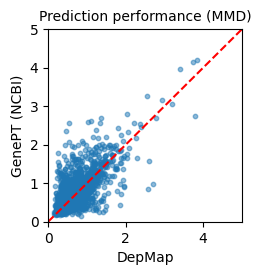

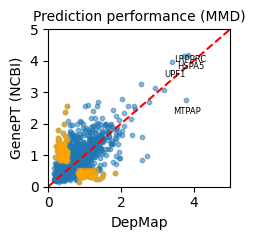

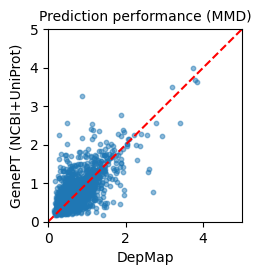

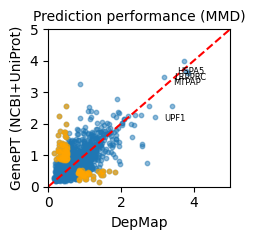

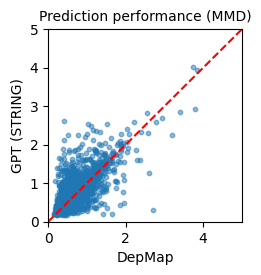

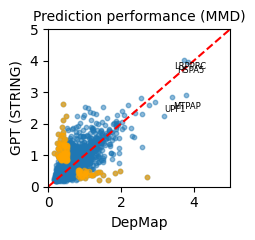

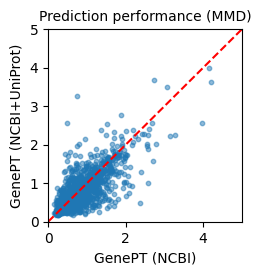

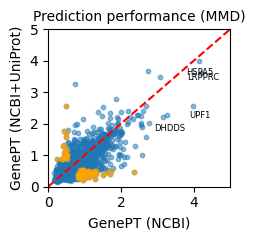

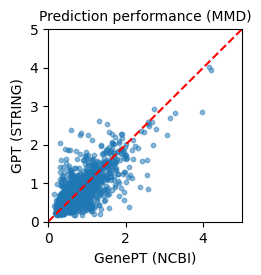

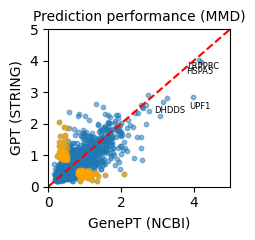

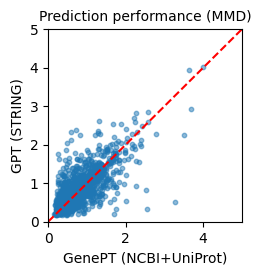

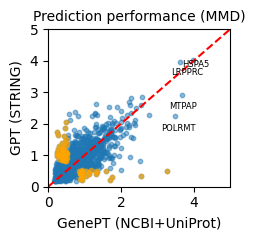

In [34]:
df = vae_attention_model_df
df['diff_genes'] = 0
priors_columns = ['DepMap_GeneEffect', 'GenePT_v1', 'GenePT_v2_large', 'STRING']
cleaned_names = ['DepMap', 'GenePT (NCBI)', 'GenePT (NCBI+UniProt)', 'GPT (STRING)']

# Parameters to adjust plot size, title size, and axis label size
plot_size = (2.5, 2.5)
title_size = 10
label_size = 10

# Generate scatter plots for each pair of priors
pairs = list(itertools.combinations(priors_columns, 2))

# Create scatter plots
for (col1, col2) in pairs:
    cleaned_col1 = cleaned_names[priors_columns.index(col1)]
    cleaned_col2 = cleaned_names[priors_columns.index(col2)]
    
    plt.figure(figsize=plot_size)
    plt.scatter(df[col1], df[col2], alpha=0.5, s=10)
    plt.xlabel(cleaned_col1, fontsize=label_size)
    plt.ylabel(cleaned_col2, fontsize=label_size)
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    plt.title(f'Prediction performance (MMD)', fontsize=title_size)
    plt.plot([0, 5], [0, 5], 'r--')  # Diagonal line
    plt.grid(False)
    plt.savefig(f'{savedir}/{col1}_{col2}.png', format='png', dpi=300)
    plt.savefig(f'{savedir}/{col1}_{col2}.svg', format='svg')
    # plt.show()

    # Identify genes with high values in col1 but low in col2, and vice versa
    high_col1_low_col2 = df[(df[col1] > high_threshold) & (df[col2] < small_threshold)]
    low_col1_high_col2 = df[(df[col1] < small_threshold) & (df[col2] > high_threshold)]

    df[f'high_{col1}_low_{col2}'] = (df[col1] > high_threshold) & (df[col2] < small_threshold)
    df[f'low_{col1}_high_{col2}'] = (df[col1] < small_threshold) & (df[col2] > high_threshold)

    # for genes in high_col1_low_col2 or low_col1_high_col2, set diff_genes to 1 in df
    high_col1_low_col2_genes = high_col1_low_col2['pert'].unique().tolist()
    low_col1_high_col2_genes = low_col1_high_col2['pert'].unique().tolist()
    df.loc[df['pert'].isin(high_col1_low_col2_genes), 'diff_genes'] = 1
    df.loc[df['pert'].isin(low_col1_high_col2_genes), 'diff_genes'] = 1

    plt.figure(figsize=plot_size)
    plt.scatter(df[col1], df[col2], alpha=0.5,s=10)
    plt.scatter(high_col1_low_col2[col1], high_col1_low_col2[col2], color='orange', alpha=0.6, s=10)
    plt.scatter(low_col1_high_col2[col1], low_col1_high_col2[col2], color='orange', alpha=0.6, s=10)
    plt.xlabel(cleaned_col1, fontsize=label_size)
    plt.ylabel(cleaned_col2, fontsize=label_size)
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    plt.title(f'Prediction performance (MMD)', fontsize=title_size)
    plt.plot([0, 5], [0, 5], 'r--')  # Diagonal line
    # plt.legend(False)
    plt.grid(False)
    plt.tight_layout()
    plt.savefig(f'{savedir}/{col1}_{col2}_highlighted.png', format='png', dpi=300)
    plt.savefig(f'{savedir}/{col1}_{col2}_highlighted.svg', format='svg')

    # Annotate the top 3 largest MMD differences on the x and y axes
    offsets = [(2, -5), (1, -10), (5, -9), (2, -11)]  # Adjust these values as needed
    top_x = df.nlargest(4, col1)
    top_y = df.nlargest(3, col2)
    for i, (idx, row) in enumerate(top_x.iterrows()):
        plt.annotate(row['pert'], (row[col1], row[col2]), textcoords="offset points", xytext=offsets[i], ha='center', fontsize=6)

    # Annotate top values in col2 with varying offsets
    # for i, (idx, row) in enumerate(top_y.iterrows()):
    #     plt.annotate(row['pert'], (row[col1], row[col2]), textcoords="offset points", xytext=offsets[i], ha='center', fontsize=8)
    plt.tight_layout()
    plt.savefig(f'{savedir}/{col1}_{col2}_highlighted_annotated.png', format='png')
    plt.show()

In [35]:
df['small_threshold'] = small_threshold
df['high_threshold'] = high_threshold
df['diff_genes'].sum()

272

In [36]:
df.to_csv(f'{savedir_parent}/diff_genes.csv', index=False)